# Imports

In [1]:
%matplotlib inline
import numpy as np
import math
import torch
from torch import nn
import time
from matplotlib import pyplot as plt
from torch.nn import functional as F

# Symbolic Programming

A simulation of a symbolic program (Since we are still using the Python interpreter here)

In [2]:
def add_():
    return '''
def add(a, b):
    return a + b
'''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
'''

def evoke_():
    return add_() + fancy_func_() + 'print(fancy_func(1, 2, 3, 4))'

prog = evoke_()
print(prog)
y = compile(prog, '', 'exec')
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
print(fancy_func(1, 2, 3, 4))
10


# Hybridization

Hybridization takes advantage of the imperative programming approach which makes the code very easy to read and debug and the fast execution and portability of symbolic programs that can avoid the bottleneck of the python interpreter

## Hybridizing the Sequential Class

In [3]:
# Factory for networks
def get_net():
    net = nn.Sequential(nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
    return net

x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[ 0.1353, -0.0302]], grad_fn=<AddmmBackward0>)

In [4]:
net = torch.jit.script(net)
net(x)

tensor([[ 0.1353, -0.0302]], grad_fn=<AddmmBackward0>)

### Benchmarking the performance improvement

While the compilation and execution seems identical to the earlier network, we can benchmark the performance to show the improvement made with hybridization

In [5]:
class Timer:
    """Recording multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [6]:
class Benchmark:
    """For measuring running time."""
    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = Timer()
        return self

    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

In [7]:
net = get_net()
with Benchmark('Without torchscript'):
    for i in range(1000): net(x)

net = torch.jit.script(net)
with Benchmark('With torchscript'):
    for i in range(1000): net(x)

Without torchscript: 0.0793 sec
With torchscript: 0.0755 sec


Here, we can see the difference in performance. As we create more complicated networks, the performance difference will matter more

### Serialization

We can serialize (save) the model and parameters on the disk to use in a front-end agnostic manner

In [8]:
net.save('my_mlp')

# Asynchronous Computation

## Asynchrony via backend

In [9]:
# Warmup for GPU computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with Benchmark('numpy'):
    for _ in range(10):
        a = np.random.normal(size=(1000, 1000))
        b = np.dot(a, a)

with Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)

Using device: cuda
numpy: 0.3482 sec
torch: 0.0017 sec


Clearly operations undertaken using numpy (CPU) are slower than operations that leverage the GPU like with PyTorch (GPU)

In [10]:
with Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

Done: 0.0021 sec


It's also clear that the advantage is not just because of the GPU. The PyTorch backend (written in C++) processes variables asynchonously while the front end (Python notebook) waits for the operations to execute

In [11]:
x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

Behind the scenes, the front end (Python in this instance) will execute the first 3 statements and will only wait for the backend (C++) before outputting the value of z

## Barriers and Blockers

In [12]:
with Benchmark('torch conversion'):
    b = torch.mm(a, a)
    b = b.cpu()
    
with Benchmark('numpy conversion'):
    b = torch.mm(a, a)
    b = b.cpu().numpy()

with Benchmark('scalar conversion'):
    b = torch.mm(a, a)
    b = b.sum().item()

torch conversion: 0.0010 sec
numpy conversion: 0.0006 sec
scalar conversion: 0.0231 sec


.numpy() and .item() conversion doesn't take advantage of asynchrony due to the implementation of numpy. Thus, these actions can slow down a program

# Automatic Parallelism

## Parallel Computation on GPUs

In [13]:
multiple_gpus = False
device_count = torch.cuda.device_count()
devices = []
if device_count == 2:
    multiple_gpus = True
for i in range(torch.cuda.device_count()):
    print(f"  Device {i}: {torch.cuda.get_device_name(i)}")
    devices.append(torch.cuda.get_device_name(i))
print(f"Multiple GPUs: {multiple_gpus}")

  Device 0: NVIDIA GeForce RTX 5070
Multiple GPUs: False


In [14]:
def run(x):
    return [x.mm(x) for _ in range(50)]
if multiple_gpus:
    x_gpu1 = torch.rand(size=(4000, 4000), device=devices[0])
    x_gpu2 = torch.rand(size=(4000, 4000), device=devices[1])
else:
    print(f"You need at least 2 GPUs to run this example")

You need at least 2 GPUs to run this example


In [15]:
if multiple_gpus:    
    run(x_gpu1)
    run(x_gpu2)  # Warm-up all devices
    torch.cuda.synchronize(devices[0])
    torch.cuda.synchronize(devices[1])

    with Benchmark('GPU1 time'):
        run(x_gpu1)
        torch.cuda.synchronize(devices[0])

    with Benchmark('GPU2 time'):
        run(x_gpu2)
        torch.cuda.synchronize(devices[1])
else:
    print(f"You need at least 2 GPUs to run this example")

You need at least 2 GPUs to run this example


In [16]:
if multiple_gpus:
    with Benchmark('GPU1 & GPU2'):
        run(x_gpu1)
        run(x_gpu2)
        torch.cuda.synchronize()
else:
    print(f"You need at least 2 GPUs to run this example")

You need at least 2 GPUs to run this example


## Parallel computation and communication

In [17]:
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]

device = torch.device('cuda' if torch.cuda.is_available() else 'none')
x_gpu1 = torch.rand(size=(4000, 4000), device=device)
run(x_gpu1)  # Warm-up
with Benchmark('Run on GPU1'):
    y = run(x_gpu1)
    torch.cuda.synchronize()
with Benchmark('Copy to CPU'):
    y_cpu = copy_to_cpu(y)
    torch.cuda.synchronize()

Run on GPU1: 0.6795 sec
Copy to CPU: 0.7793 sec


Clearly copying the tensor to CPU is expensive

In [18]:
with Benchmark('Run on GPU1 and copy to CPU'):
    y = run(x_gpu1)
    y_cpu = copy_to_cpu(y, True)
    torch.cuda.synchronize()

Run on GPU1 and copy to CPU: 1.9932 sec


# Training on multiple GPUs

In [19]:
# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

## Data synchronization

In [20]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_(True)
    return new_params

In [21]:
new_params = get_params(params, device)
print('b1 weight: ', new_params[1])
print('b1 grad: ', new_params[1].grad)


b1 weight:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad:  None


In [22]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

In [23]:
data = [torch.ones((1, 2), device=device) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:0')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:0')


## Distributing data

In [24]:
data = torch.arange(20).reshape(4, 5)
# Get available devices
devices = []
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    devices = [torch.device(f'cuda:{i}') for i in range(num_gpus)]
    if len(devices) == 0:
        devices = [torch.device('cpu')]
else:
    devices = [torch.device('cpu')]

# Split data across available devices
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0)]
output: (tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'),)


In [25]:
def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

## Training

In [26]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # Loss is calculated separately on each GPU
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # Backpropagation is performed separately on each GPU
        l.backward()
    # Sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # The model parameters are updated separately on each GPU
    for device_W in device_params:
        with torch.no_grad():
            for param in device_W:
                if param.grad is not None:
                    param -= lr * param.grad / X.shape[0]
                    param.grad.zero_()

In [27]:
from torchvision import transforms
import torchvision
def linreg(X, w, b):
    """Linear regression model."""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """Squared loss function."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = 0.0
    num_batches = 0
    with torch.no_grad():
        for X, y in data_iter:
            l = loss(net(X), y)
            metric += l.sum()
            num_batches += y.numel()
    return metric / num_batches


class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory.

    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

In [28]:
class Timer:
    """Recording multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

class Animator:  # Define a new Animator class that properly handles None values
	def __init__(self, xlabel=None, ylabel=None, legend=None):
		self.data = {'train_loss': [], 'train_acc': [], 'test_acc': []}
		self.epochs = []
		
	def add(self, epoch, metrics):
		self.epochs.append(epoch)
		train_loss, train_acc, test_acc = metrics
		if train_loss is not None:
			self.data['train_loss'].append(float(train_loss))
		if train_acc is not None:
			self.data['train_acc'].append(float(train_acc))
		if test_acc is not None:
			self.data['test_acc'].append(float(test_acc))
			
	def show(self):
		plt.figure(figsize=(10, 6))
		for label, values in self.data.items():
			if values:  # Only plot if we have data
				plt.plot(self.epochs[:len(values)], values, label=label)
		plt.xlabel('Epoch')
		plt.ylabel('Metric Value')
		plt.legend()
		plt.grid(True)
		plt.show()
    
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.to(y.dtype) == y
    return float(cmp.sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

In [29]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = load_data_fashion_mnist(batch_size)
    # Copy model parameters to `num_gpus` GPUs
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = Animator(xlabel='epoch', ylabel='test acc')
    timer = Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # Evaluate the model on GPU 0
        test_acc = evaluate_accuracy_gpu(lambda x: lenet(x, device_params[0]), test_iter, devices[0])
        animator.add(epoch + 1, (None, None, test_acc))  # Provide all three metrics (train_loss, train_acc, test_acc)
    print(f'test acc: {test_acc:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')
    animator.show()

test acc: 0.85, 6.4 sec/epoch on [device(type='cuda', index=0)]


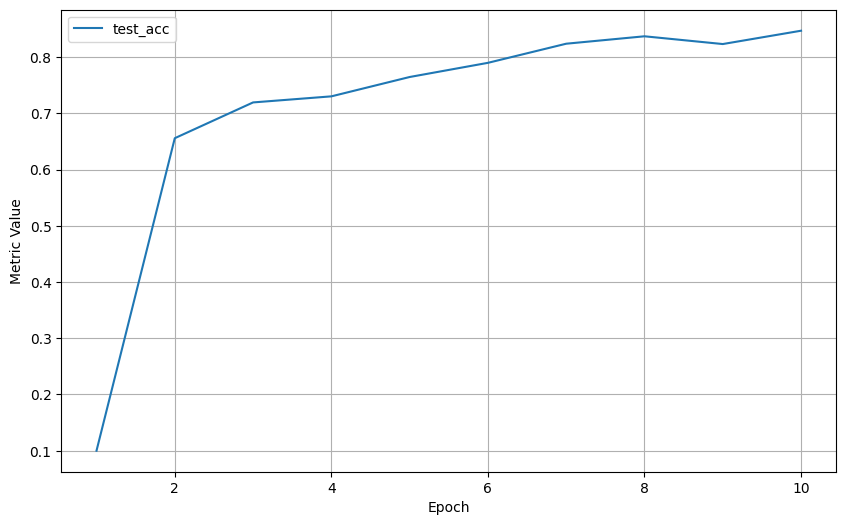

In [30]:
from torch.utils import data

train(num_gpus=1, batch_size=256, lr=0.2)

In [31]:
# Try to train with 2 GPUs if available
if len(devices) > 1:
    train(num_gpus=2, batch_size=512, lr=0.2)
else:
    print(f"You need at least 2 GPUs to run this example")

You need at least 2 GPUs to run this example


# Concise implementation for multiple GPUs

In [32]:
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.relu(Y)
    
def resnet18(num_classes, in_channels=1):
    def resnet_block(in_channels, num_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channels, num_channels, use_1x1conv=True,
                                        strides=2))
            else:
                blk.append(Residual(num_channels, num_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the max-pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [33]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = load_data_fashion_mnist(batch_size)
    def init_weights(module):
        if type(module) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)
    # Set the model on multiple GPUs
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = Timer(), 10
    animator = Animator(xlabel='epoch',ylabel= 'test acc')
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        test_acc = evaluate_accuracy_gpu(net, test_iter, devices[0])
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'test acc: {test_acc:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')
    animator.show()

test acc: 0.89, 21.6 sec/epoch on [device(type='cuda', index=0)]


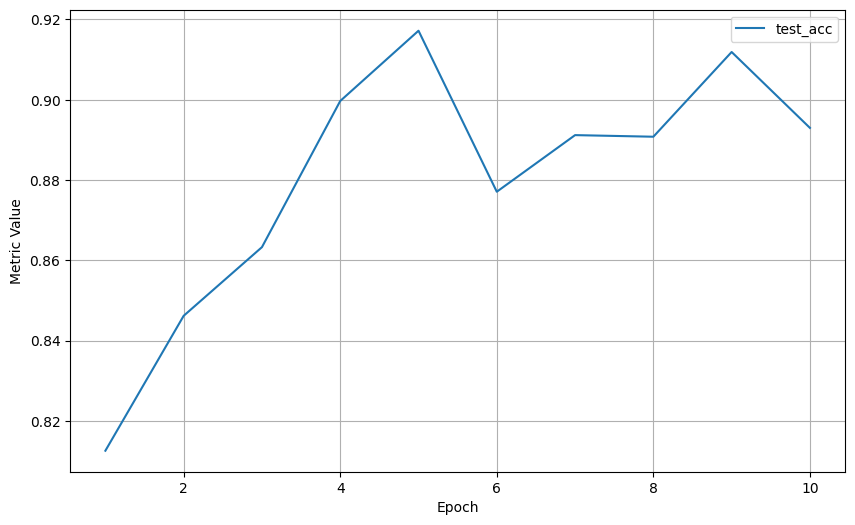

In [34]:
net = resnet18(10) 
train(net=net, num_gpus=1, batch_size=256, lr=0.1)

In [35]:
# Try to train with 2 GPUs if available
if len(devices) > 1:
    train(num_gpus=2, batch_size=512, lr=0.2)
else:
    print(f"You need at least 2 GPUs to run this example")

You need at least 2 GPUs to run this example
